# Online Product Recommendation

In this repo, I Implemented word2vec NLP Model to create a Recommendation engine that automatically recommends a certain number of products to its consumers based on historical purchase behavior.

The E-Commerce data is taken from the UCI repository http://archive.ics.uci.edu/ml/machine-learning-databases/00352/

-------------------------------------------------------



#### Import Libraries and Load Data




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Projects/Word2vec recommendation model

/content/drive/My Drive/Colab Notebooks/Projects/Word2vec recommendation model


In [3]:
!ls

'Online Retail.xlsx'   word2vec_2.model  'Word2Vec recommendation.ipynb'


In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Online Retail.xlsx')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Given below is the description of the fields in this dataset:

1. __InvoiceNo:__ Invoice number, a unique number assigned to each transaction.
2. __StockCode:__ Product/item code. a unique number assigned to each distinct product.
3. __Description:__ Product description
4. __Quantity:__ The quantities of each product per transaction.
5. __InvoiceDate:__ Invoice Date and time. The day and time when each transaction was generated.
6. __CustomerID:__ Customer number, a unique number assigned to each customer.



In [7]:
df.shape

(541909, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The dataset contains 541,909 transactions. That is a pretty good number for us.

-------------------------------------------------------

### Check for Missing Data

-------------------------------------------------------



In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Since we have sufficient data, we will drop all the rows with missing values.

In [10]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

-------------------------------------------------------

### Data Preparation for Model

-------------------------------------------------------



Let's convert the StockCode to string datatype.

In [ ]:
df['StockCode']= df['StockCode'].astype(str)

Let's check out the number of unique customers in our dataset.

In [12]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

It is a good practice to set aside a small part of the dataset for validation purpose. Therefore, I will use data of 90% of the customers to create word2vec embeddings. Let's split the data.

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [14]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:04<00:00, 880.00it/s]


In [15]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1185.01it/s]


-------------------------------------------------------


### Lets Build word2vec Embeddings for Products

-------------------------------------------------------



Note : As Model Training going to take some time So You can skip or stop below cell, if you can't wait to train your model and Directly load pretrain model from Next cell :

In [ ]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

# save word2vec model
model.save("word2vec.model")

In [ ]:
model = Word2Vec.load("word2vec.model")

As we do not plan to train the model any further, 
we are calling init_sims(), which will make the model much more memory-efficient.

In [ ]:
model.init_sims(replace=True)

In [23]:
print(model)

Word2Vec(vocab=3169, size=100, alpha=0.03)


Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [24]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3169, 100)

-------------------------------------------------------

### Visualize word2vec Embeddings

-------------------------------------------------------



It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can't even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction. 

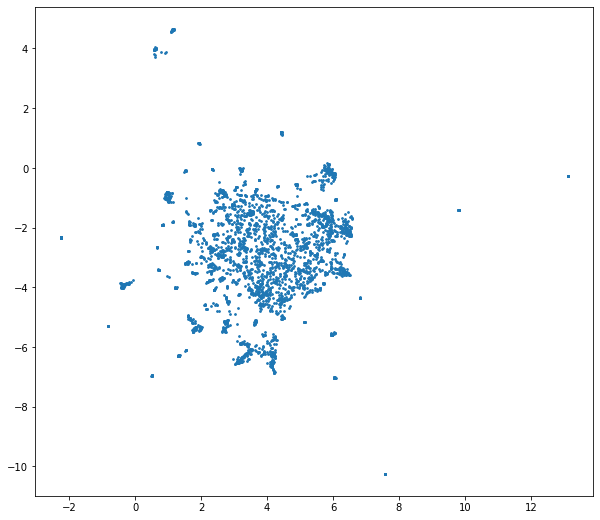

In [25]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these datapoints. These are groups of similar products.

-------------------------------------------------------

### Start Recommending Products

-------------------------------------------------------



### Congratulations! 

We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector. 

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [ ]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [27]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

<br>

I have defined the function below. It will take a product's vector (n) as input and return top 6 similar products.

In [ ]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Let's try out our function by passing the vector of the product '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [29]:
similar_products(model['90019A'])

[('GREEN HEART OF GLASS BRACELET', 0.798067569732666),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7823165655136108),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7776885032653809),
 ('PINK BOUDICCA LARGE BRACELET', 0.774724006652832),
 ('JADE DROP EARRINGS W FILIGREE', 0.7740833759307861),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.7625738978385925)]

<br>

Cool! The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases he or she has made in the past?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [31]:
len(purchases_val[0])

359

The length of the first list of products purchased by a user is 314. We will pass this products' sequence of the validation set to the function *aggregate_vectors*.

In [32]:
aggregate_vectors(purchases_val[0]).shape

(100,)

Well, the function has returned an array of 100 dimension. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [33]:
similar_products(aggregate_vectors(purchases_val[0]))

[('TOY TIDY PINK POLKADOT', 0.7047410011291504),
 ('JUMBO STORAGE BAG SKULLS', 0.7007169723510742),
 ('LUNCH BAG CARS BLUE', 0.6992664933204651),
 ('LUNCH BAG RED RETROSPOT', 0.6990112662315369),
 ('JUMBO BAG RED RETROSPOT', 0.6974446773529053),
 ('CHARLOTTE BAG SUKI DESIGN', 0.6944633722305298)]

As it turns out, our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on the last few purchases only then also you can use the same set of functions.

Below I am giving only the last 10 products purchased as input.

In [34]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('TOY TIDY PINK POLKADOT', 0.7472281455993652),
 ('JUMBO STORAGE BAG SKULLS', 0.7310079336166382),
 ('JUMBO BAG RED RETROSPOT', 0.7146239280700684),
 ('JUMBO BAG PINK POLKADOT', 0.6919957399368286),
 ('JUMBO SHOPPER VINTAGE RED PAISLEY', 0.6838316321372986),
 ('JUMBO BAG STRAWBERRY', 0.6834717392921448)]

---------------------------------------
### Thats it for Now

up next we will look forward to Test and perfrom different NLP Approach.
